# Discharge timeseries
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 28-01-2025*<br>

**Introduction**<br>



**Output**<br>


In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
# from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

## Configuration

In [81]:
VAR = 'discharge'

# inputs
PATH_IN = Path('../data') / VAR
POINTS_FILE = PATH_IN / 'outlets_5000km2_ocean.shp'
TS_FILE = PATH_IN / f'{VAR}_outlets.nc'

# outputs
PATH_OUT = Path('../results') / VAR
PATH_PLOT = PATH_OUT / 'plots'
PATH_PLOT.mkdir(parents=True, exist_ok=True)

# climatology
START = datetime(1991, 1, 1)
END = datetime(2020, 12, 31)

In [3]:
map_variables = {
    'runoff': 'rowe',
    'discharge': 'dis24'
}

var_shortname = map_variables[VAR]

## Data

### River outlets

In [4]:
# load modified river outlets
outlets = gpd.read_file(POINTS_FILE)

# rename columns and index
outlets.rename(columns={'y': 'latitude', 'x': 'longitude', 'Band1': 'area'}, inplace=True)
outlets.drop(['band', 'crs'], axis=1, inplace=True, errors='ignore')
outlets.index.name = 'ID'

### Discharge time series

In [5]:
# load extracted discharge time series at the outlets
dis = xr.open_dataset(TS_FILE)[var_shortname]

# rename or drop variables
dis = dis.drop_vars('surface', errors='ignore')
dis = dis.rename({'valid_time': 'time'})

# convert time convention to beginning-of-timestep
dis['time'] = dis['time'] - pd.Timedelta(days=1)

## Processing

### Interannual variability of freshwater discharge
Annual time series and monthly anomalies of freshwater discharge ($\frac{km^3}{yr}$) into the 4 oceans.

In [6]:
dis_year = {}

for ocean in tqdm(outlets.ocean.unique()):

    # rivers draining to that ocean basin
    IDs = outlets[outlets.ocean == ocean].index.tolist()

    # compute time series of total annual discharge into that ocean
    serie = dis.sel(ID=IDs).sum('ID').resample(time='1Y').mean(skipna=True).to_pandas()

    # convert from m3/s to km3/year
    serie *= 3600 * 24 * 365 * 1e-9

    dis_year[ocean] = serie

# convert to DataFrame
dis_year = pd.DataFrame.from_dict(dis_year)
# set index to the first day of the year
dis_year.index = [idx.year for idx in dis_year.index]

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
# compute anomaly
annual_anomaly = dis_year - dis_year.loc[START.year:END.year].mean(axis=0)
annual_anomaly.index.name = 'year'

In [16]:
# export
output_file = PATH_OUT / f'{VAR}_annual_anomaly_by_ocean.csv'
annual_anomaly.to_csv(output_file, float_format='%.0f')
print(f'Annual anomalies of discharge saved in:\t{output_file}')

Annual anomalies of discharge saved in:	..\results\discharge\discharge_annual_anomaly_by_ocean.csv


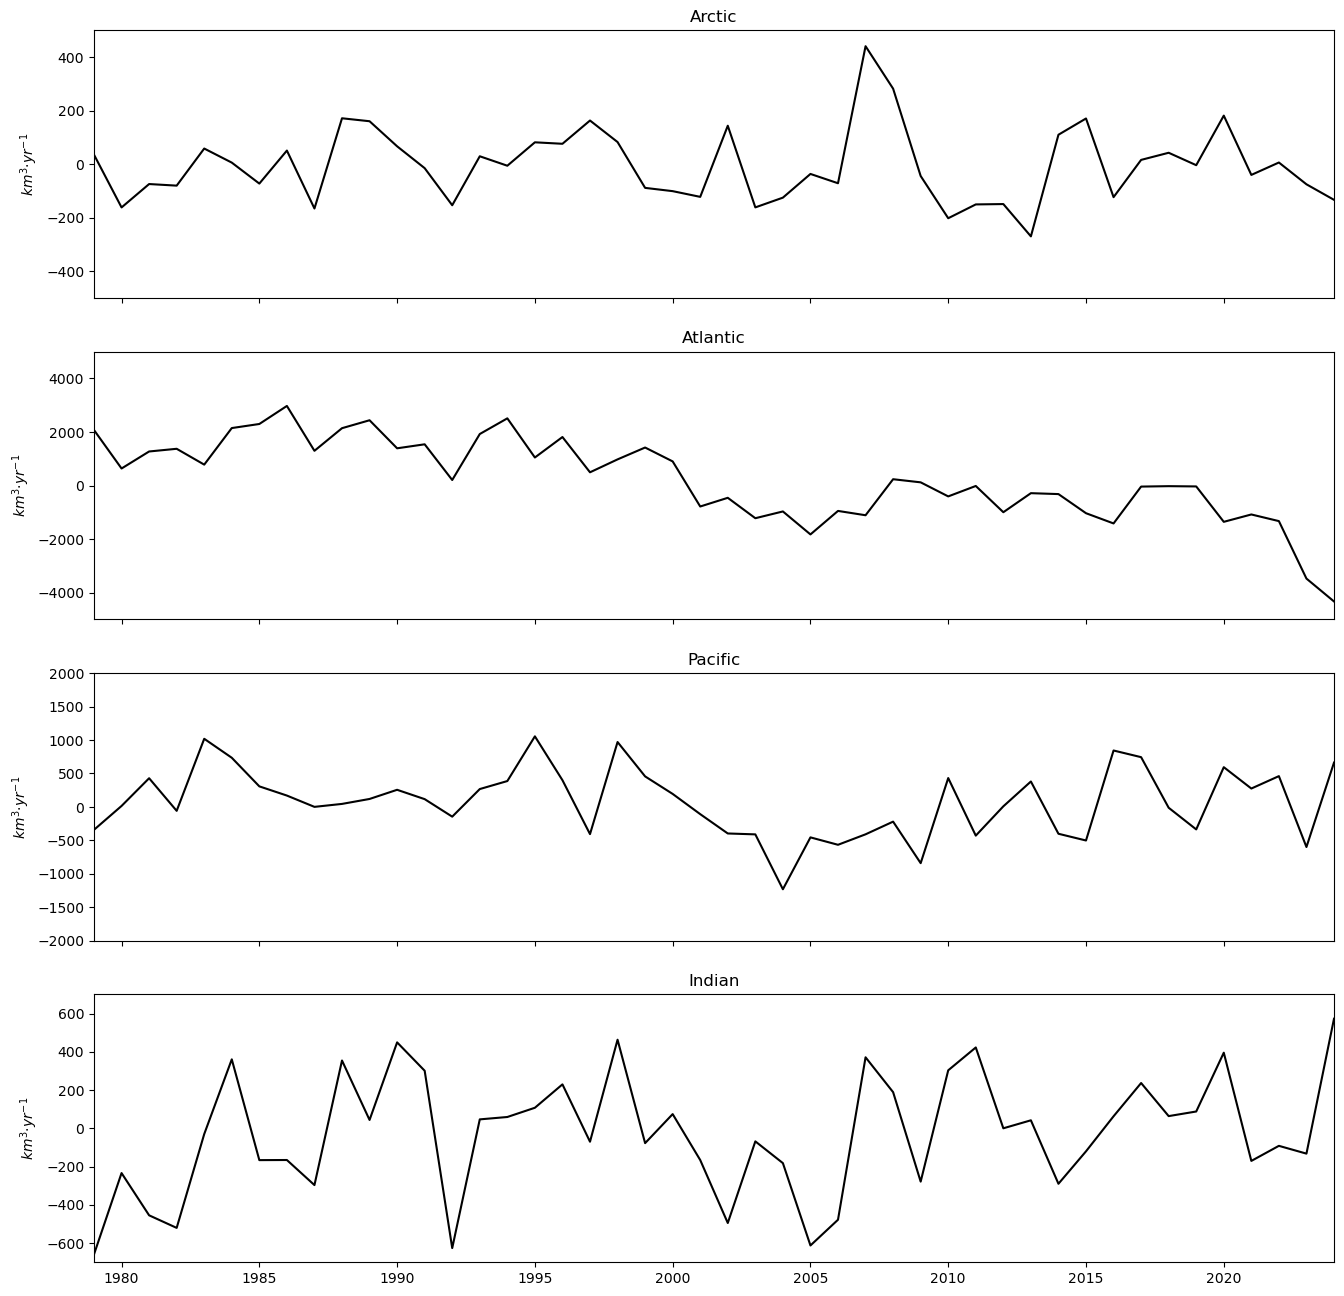

In [89]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 16), sharex=True)

for ax, ocean in zip(axes, annual_anomaly.columns):
    anomaly = annual_anomaly[ocean]
    
    # lineplot of annual anomalies
    ax.plot(anomaly, c='k', lw=1.5, zorder=2)
    
    # # colour matrix of monthly anomalies
    # ax.imshow(monthly_dis.sel(ocean=ocean) - seasonality.sel(ocean=ocean), zorder=0, cmap='BrBG')
    
    vmax = max(abs(anomaly.max()), abs(anomaly.min()))
    exp = len(str(int(vmax))) - 1
    vmax = np.ceil(vmax / 10**exp) * 10**exp
    
    ax.set(
        xlim=(anomaly.index.min(), anomaly.index.max()),
        ylim=(-vmax, vmax),
        ylabel=r'$km^3·yr^{-1}$',
        title=ocean
    )
    
plt.savefig(PATH_PLOT / 'annual_anomaly_by_ocean.jpg', dpi=300, bbox_inches='tight')

### Seasonality of freshwater discharge

* [x] Monthly average discharge (climatoloty) in km3/yr
* [x] Standard deviation of the monthly discharge (climatology)
* [x] monthly discharge in 2024

#### Monthly time series of discharge

In [60]:
dis_month = {}
for ocean in tqdm(outlets.ocean.unique()):

    # rivers draining to that ocean basin
    IDs = outlets[outlets.ocean == ocean].index.tolist()

    # compute time series of total annual discharge into that ocean
    serie = dis.sel(ID=IDs).sum('ID').resample(time='1M').mean(skipna=True).to_pandas()

    # convert from m3/s to km3/year
    serie *= 3600 * 24 * 365 * 1e-9

    dis_month[ocean] = serie

# convert to DataFrame
dis_month = pd.DataFrame.from_dict(dis_month)

# set index to the first day of the month
dis_month.index = [datetime(idx.year, idx.month, 1) for idx in dis_month.index]
dis_month['year'] = dis_month.index.year
dis_month['month'] = dis_month.index.month

# convert to DataArray
ls = []
for ocean in tqdm(outlets.ocean.unique()):
    # pivot the ocean time series
    df = dis_month.pivot(index='month', columns='year', values=ocean)
    
    # convert to xarray.DataArray
    da = xr.DataArray(
        df.values, 
        dims=("month", "year"), 
        coords={
            "month": df.index,
            "year": df.columns,
        },
        name='monthly_discharge'
    )
    
    # add new coordinate: 'ocean'
    da = da.expand_dims(ocean=[ocean])
    
    ls.append(da)
    
# concatenate oceans
dis_month = xr.concat(ls, dim='ocean')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Climatology vs last year

In [76]:
# climatology of monthly discharge
seasonality = xr.Dataset({
    'mean': dis_month.sel(year=slice(START.year, END.year)).mean('year'),
    'std': dis_month.sel(year=slice(START.year, END.year)).std('year')
})

In [77]:
# monthly discharge 2024
seasonality['2024'] = dis_month.sel(year=2024).drop_vars('year')

In [80]:
# export
output_file = PATH_OUT / f'{VAR}_seasonality_by_ocean.nc'
seasonality.to_netcdf(output_file)
print(f'Discharge seasonality saved in:\t{output_file}')

Discharge seasonality saved in:	..\results\discharge\discharge_seasonality_by_ocean.nc


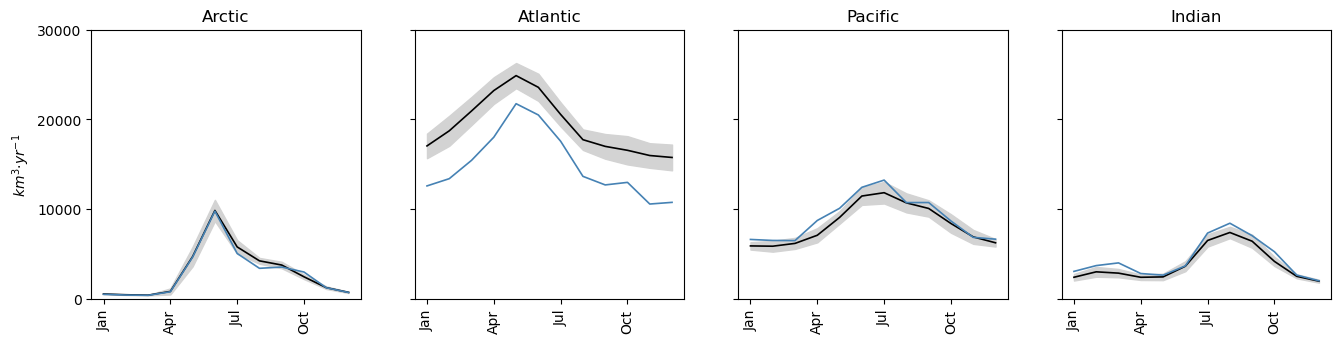

In [82]:
fig, axes = plt.subplots(ncols=4, figsize=(16, 3.5), sharey=True)

for ax, ocean in zip(axes, outlets.ocean.unique()):
    # extract monthly values
    mean = seasonality['mean'].sel(ocean=ocean).to_pandas()
    std = seasonality['std'].sel(ocean=ocean).to_pandas()
    target = seasonality['2024'].sel(ocean=ocean).to_pandas()
    
    ax.fill_between(
        seasonality.month,
        mean - std,
        mean + std,
        color='lightgray',
        # alpha=.5,
        zorder=0
    )
    ax.plot(mean, c='k', lw=1.2, zorder=1)
    ax.plot(target, c='steelblue', lw=1.2, zorder=2)
    ax.set(
        title=ocean,
        ylim=(0, 3e4),
        yticks=[0, 1e4, 2e4, 3e4],
        xticks=range(1, 13, 3),
    )
    ax.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct'], rotation=90)
    if ax == axes[0]:
        ax.set_ylabel(r'$km^3·yr^{-1}$')
        
plt.savefig(PATH_PLOT / f'{VAR}_seasonality_by_ocean.jpg', dpi=300, bbox_inches='tight')

### Monthly anomalies

In [99]:
# compute
monthly_anomalies = dis_month - seasonality['mean']

In [110]:
# export
output_file = PATH_OUT / f'{VAR}_monthly_anomaly_by_ocean.nc'
monthly_anomalies.to_netcdf(output_file)
print(f'Discharge monthly anomalies saved in:\t{output_file}')

Discharge monthly anomalies saved in:	..\results\discharge\discharge_monthly_anomaly_by_ocean.nc


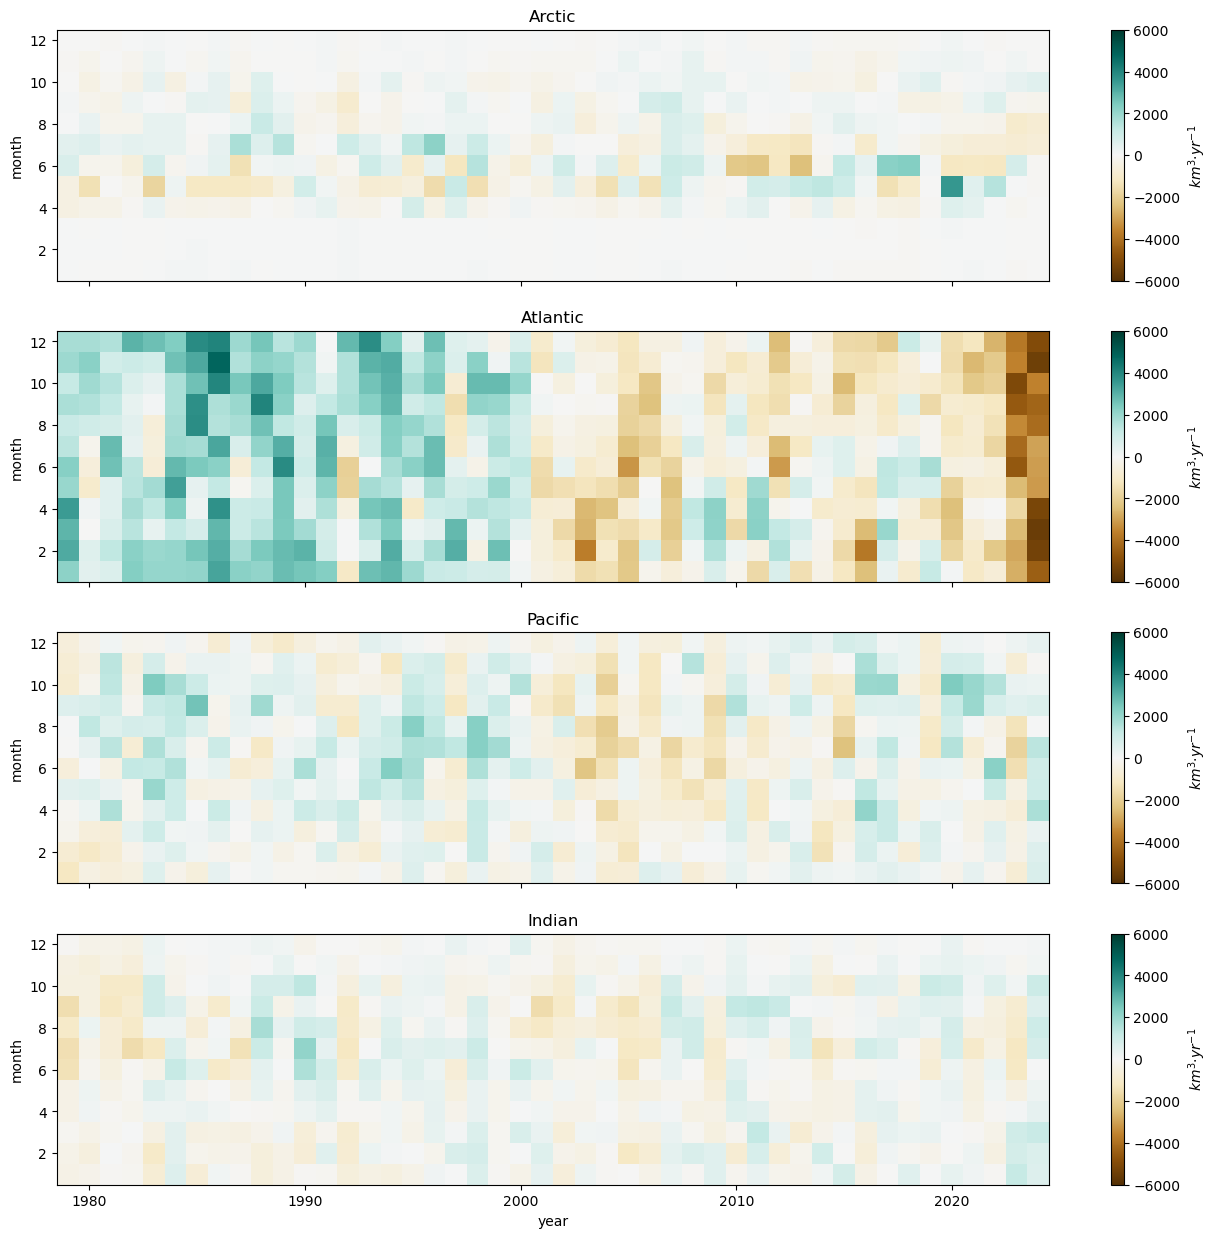

In [118]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 15), sharex=True)

for ax, ocean in zip(axes, outlets.ocean.unique()):
    
    monthly_anomalies.sel(ocean=ocean).plot(
        ax=ax,
        cmap='BrBG',
        vmin=-6000,
        vmax=6000,
        cbar_kwargs={'label': r'$km^3·yr^{-1}$'}
    )
    
    ax.set(
        title=ocean
    )
    if ax != axes[-1]:
        ax.set_xlabel(None)
        
plt.savefig(PATH_PLOT / 'monthly_anomaly_by_ocean.jpg', dpi=300, bbox_inches='tight')